In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Train

In [5]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D # CNN.
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator # Use data augmentation.
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

### Load Dataset

In [6]:
# Use a dataset that has already been created.
x_train = np.load('Data/x_train.npy').astype(np.float32)
y_train = np.load('Data/y_train.npy').astype(np.float32)
x_val = np.load('Data/x_val.npy').astype(np.float32)
y_val = np.load('Data/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


### Preview

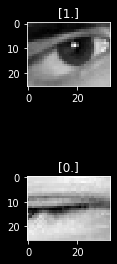

In [7]:
plt.subplot(3, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(3, 1, 3)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

### Data Augmentation

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # 0~255사이의 이미지를 0~1사이로 바꿈.
    rotation_range=10, # 이미지를 +-10도 회전.
    width_shift_range=0.2, # 가로 크기 변형.
    height_shift_range=0.2, # 세로 크기 변형.
    shear_range=0.2 # 이미지를 비틈.
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

### Model

In [9]:
inputs = Input(shape=(26, 34, 1)) # 세로 26, 가로 34인 gray-scale 이미지를 input으로 사용.

# 커널 수만 32, 64, 128 순으로 3번 변경 진행.
net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net) # 차원축소를 위해 Maxpooling2D 사용.

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net) # convolution layer를 1차원으로 길게 펼침.

net = Dense(512)(net) # Dense layer로 512개의 Fully connected layer를 연결.
net = Activation('relu')(net)
net = Dense(1)(net) # 0~1사이의 값으로 출력하기 위해 필요.
outputs = Activation('sigmoid')(net) # sigmoid 함수로 0~1사의 값을 가지도록 함.

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# adam optimizer를 사용하고, 0, 1을 판단하는 것이기에 loss는 binary_crossentropy를 사용.

model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26, 34, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 8, 128)         73856     
______________________________

In [10]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('Model/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1), # 모델이 좋을 경우, 저장.
        ReduceLROnPlateau(monitor='val_acc',factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05) # 학습이 잘 되지 않을 경우, learning_rate를 줄이도록 설정.
    ]
)
# generator로 데이터를 불러온 경우에는 fit_generator로 학습시켜주는 것이 좋음.


Epoch 1/50
81/81 [==============================] - 3s 40ms/step - loss: 0.4802 - acc: 0.7753 - val_loss: 0.3569 - val_acc: 0.8681

Epoch 00001: val_acc improved from -inf to 0.86806, saving model to Model/2020_03_19_15_51_42.h5
Epoch 2/50
81/81 [==============================] - 3s 36ms/step - loss: 0.2658 - acc: 0.8921 - val_loss: 0.1458 - val_acc: 0.9618

Epoch 00002: val_acc improved from 0.86806 to 0.96181, saving model to Model/2020_03_19_15_51_42.h5
Epoch 3/50
81/81 [==============================] - 3s 37ms/step - loss: 0.1678 - acc: 0.9374 - val_loss: 0.1250 - val_acc: 0.9688

Epoch 00003: val_acc improved from 0.96181 to 0.96875, saving model to Model/2020_03_19_15_51_42.h5
Epoch 4/50
81/81 [==============================] - 3s 39ms/step - loss: 0.1180 - acc: 0.9590 - val_loss: 0.2121 - val_acc: 0.9618

Epoch 00004: val_acc did not improve from 0.96875
Epoch 5/50
81/81 [==============================] - 3s 39ms/step - loss: 0.1178 - acc: 0.9582 - val_loss: 0.0667 - val_acc: 

81/81 [==============================] - 3s 38ms/step - loss: 0.0041 - acc: 0.9988 - val_loss: 0.0012 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
81/81 [==============================] - 4s 49ms/step - loss: 0.0046 - acc: 0.9985 - val_loss: 8.8801e-04 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000

Epoch 00043: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 44/50
81/81 [==============================] - 4s 47ms/step - loss: 0.0040 - acc: 0.9985 - val_loss: 9.6113e-04 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
81/81 [==============================] - 4s 47ms/step - loss: 0.0042 - acc: 0.9985 - val_loss: 7.2060e-04 - val_acc: 1.0000

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
81/81 [==============================] - 4s 44ms/step - loss: 0.0041 - acc: 0.9992 - val_loss: 9.4295e-04 - val_acc: 1.0000

Epoch 00046: val_acc did not improve from 1.00000

### Confusion Matrix

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

test acc: 1.0


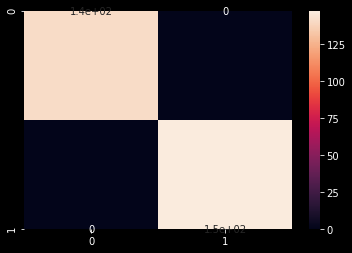

In [12]:
model = load_model('Model/%s.h5' % (start_time)) # keras 모델을 로드.

y_pred = model.predict(x_val/255.) # model.predict()_모델을 통해 데이터를 예측. 0~1사이로 바꾸었기 때문에 /255.
y_pred_logical = (y_pred > 0.5).astype(np.int) 
# y_pred가 0.5보다 크면 눈을 뜬 이미지로 인식, 작으면 눈을 감은 이미지로 인식하도록. True면 눈을 뜬 것, False면 눈을 감은 것. 그리고 이걸 np.int를 통해 0과 1로 변환.(0은 감은 것, 1이면 눈을 뜬 것.)

print('test acc: %s' % accuracy_score(y_val, y_pred_logical)) # accuracy_score()_테스트 결과 정확도를 계산.
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

# Test

In [14]:
import cv2, dlib
import numpy as np
from imutils import face_utils
from keras.models import load_model

In [15]:
IMG_SIZE = (34, 26)

In [16]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('Data/shape_predictor_68_face_landmarks.dat')

model = load_model('Model/2020_03_19_15_51_42.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26, 34, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 4, 128)         0   

In [17]:
def crop_eye(img, eye_points):
    x1, y1 = np.amin(eye_points, axis=0)
    x2, y2 = np.amax(eye_points, axis=0)
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

    w = (x2 - x1) * 1.2
    h = w * IMG_SIZE[1] / IMG_SIZE[0]

    margin_x, margin_y = w / 2, h / 2

    min_x, min_y = int(cx - margin_x), int(cy - margin_y)
    max_x, max_y = int(cx + margin_x), int(cy + margin_y)

    eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

    eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

    return eye_img, eye_rect

In [18]:
cap = cv2.VideoCapture('Data/video.mp4')

while cap.isOpened():
    ret, img_ori = cap.read()

    if not ret:
        break

    img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)

    img = img_ori.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)

    for face in faces:
        shapes = predictor(gray, face)
        shapes = face_utils.shape_to_np(shapes)

        eye_img_1, eye_rect_1 = crop_eye(gray, eye_points=shapes[36:42])
        eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])

        eye_img_1 = cv2.resize(eye_img_1, dsize=IMG_SIZE)
        eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
        eye_img_r = cv2.flip(eye_img_r, flipCode=1)

        cv2.imshow('1', eye_img_1)
        cv2.imshow('r', eye_img_r)

        eye_input_1 = eye_img_1.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
        eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

        pred_1 = model.predict(eye_input_1)
        pred_r = model.predict(eye_input_r)

        state_1 = '0 %.1f' if pred_1 > 0.1 else '- %.1f'
        state_r = '0 %.1f' if pred_r > 0.1 else '- %.1f'

        state_1 = state_1 % pred_1
        state_r = state_r % pred_r

        cv2.rectangle(img, pt1=tuple(eye_rect_1[0:2]), pt2=tuple(eye_rect_1[2:4]), color=(255, 255, 255), thickness=2)
        cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255, 255, 255), thickness=2)

        cv2.putText(img, state_1, tuple(eye_rect_1[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    cv2.imshow('result', img)
    if cv2.waitKey(1) == ord('q'):
        break